## Using lifespan models to make predictions on new data

This notebook shows how to apply the coefficients from [pre-estimated normative models](https://elifesciences.org/articles/72904) to new data. This can be done in two different ways: (i) using a new set of data derived from the same sites used to estimate the model and (ii) on a completely different set of sites. In the latter case, we also need to estimate the site effect, which requires some calibration/adaptation data. As an illustrative example, we use a dataset derived from the [1000 functional connectomes project](https://www.nitrc.org/forum/forum.php?thread_id=2907&forum_id=1383) and adapt the learned model to make predictions on these data.

First, if necessary, we install PCNtoolkit (note: please, be sure to install the version 0.30.post2)

In [ ]:
%%capture
! pip install pcntoolkit==0.33

In [ ]:
! git clone https://github.com/predictive-clinical-neuroscience/braincharts.git

fatal: destination path 'braincharts' already exists and is not an empty directory.


In [ ]:
# we need to be in the scripts folder when we import the libraries in the code block below,
# because there is a function called nm_utils that is in the scripts folder that we need to import
import os
os.chdir('/content/braincharts/scripts/')

Now we import the required libraries

In [ ]:
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import remove_bad_subjects, load_2d

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/pytensor/tensor/random/op.py:97: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pytensor/tensor/random/op.py:107: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


We need to unzip the models.

In [ ]:
os.chdir('/content/braincharts/models/')

In [ ]:
ls

lifespan_12K_57sites_mqc2_train.zip  lifespan_smith10_17K_40sites.tar.gz
lifespan_12K_59sites_mqc_train.zip   lifespan_smith10_22K_40sites.tar.gz
lifespan_23K_57sites_mqc2.zip        lifespan_yeo17_17K_40sites.tar.gz
lifespan_29K_82sites_train.zip       lifespan_yeo17_22K_40sites.tar.gz
lifespan_57K_82sites.zip             README.md
lifespan_DK_46K_59sites_train.zip    surfacearea_20K_66sites_train.zip
lifespan_DK_46K_59sites.zip          surfacearea_40K_66sites.tar.gz
lifespan_fa_24K_19sites.zip          surfacearea_DK_46K_59sites.zip
lifespan_sa_DK_46K_59sites.zip


In [ ]:
%%capture
# we will use the biggest sample as our training set (approx. N=57000 subjects from 82 sites)
# for more info on the other pretrained models available in this repository,
! unzip lifespan_57K_82sites.zip

Next, we configure some basic variables, like where we want the analysis to be done and which model we want to use.

**Note:** We maintain a list of site ids for each dataset, which describe the site names in the training and test data (`site_ids_tr` and `site_ids_te`), plus also the adaptation data . The training site ids are provided as a text file in the distribution and the test ids are extracted automatically from the pandas dataframe (see below). If you use additional data from the sites (e.g. later waves from ABCD), it may be necessary to adjust the site names to match the names in the training set. See the accompanying [paper](https://elifesciences.org/articles/72904) for more details.

In [ ]:
# which model do we wish to use?
model_name = 'lifespan_57K_82sites'
site_names = 'site_ids_ct_82sites.txt'

# where the analysis takes place
root_dir = '/content/braincharts'
out_dir = os.path.join(root_dir, 'models', model_name)

# load a set of site ids from this model. This must match the training data
with open(os.path.join(root_dir,'docs', site_names)) as f:
    site_ids_tr = f.read().splitlines()

### Download test dataset

As mentioned above, to demonstrate this tool we will use a test dataset derived from the [FCON 1000](https://fcon_1000.projects.nitrc.org/) dataset. We provide a prepackaged training/test split of these data in the required format (also after removing sites with only a few data points), [here](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/tree/main/data). you can get these data by running the following commmands:

In [ ]:
os.chdir(root_dir)
!wget -nc https://raw.githubusercontent.com/saigerutherford/CPC_ML_tutorial/master/data/fcon1000_tr.csv
!wget -nc https://raw.githubusercontent.com/saigerutherford/CPC_ML_tutorial/master/data/fcon1000_te.csv

--2025-07-13 06:05:38--  https://raw.githubusercontent.com/saigerutherford/CPC_ML_tutorial/master/data/fcon1000_tr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786940 (768K) [text/plain]
Saving to: ‘fcon1000_tr.csv’

fcon1000_tr.csv     100%[===================>] 768.50K  --.-KB/s    in 0.04s   

2025-07-13 06:05:38 (19.0 MB/s) - ‘fcon1000_tr.csv’ saved [786940/786940]

--2025-07-13 06:05:38--  https://raw.githubusercontent.com/saigerutherford/CPC_ML_tutorial/master/data/fcon1000_te.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 

### Load test data

Now we load the test data and remove some subjects that may have poor scan quality. This asssesment is based on the Freesurfer Euler characteristic as described in the papers below.

**Note:** For the purposes of this tutorial, we make predictions for all sites in the FCON 1000 dataset, but two of them were also included in the training data (named 'Baltimore' and 'NewYork_a'). In this case, this will only slightly bias the accuracy, but in order to replicate the results in the paper, it would be necessary to additionally remove these sites from the test dataframe.

**References**
- [Kia et al 2022](https://pubmed.ncbi.nlm.nih.gov/36480551/)
- [Rosen et al 2018](https://www.sciencedirect.com/science/article/abs/pii/S1053811917310832?via%3Dihub)

In [ ]:
test_data = os.path.join(root_dir, 'fcon1000_te.csv')

df_te = pd.read_csv(test_data, index_col=0)

# remove some bad subjects
df_te, bad_sub = remove_bad_subjects(df_te, df_te)

# extract a list of unique site ids from the test set
site_ids_te =  sorted(set(df_te['site'].to_list()))

18 subjects are removed!


### Load adaptation data

If the data you wish to make predictions for is not derived from the same scanning sites as those in the trainig set, it is necessary to learn the [site effect](https://pubmed.ncbi.nlm.nih.gov/36388214/) so that we can account for it in the predictions. In order to do this in an unbiased way, we use a separate dataset, which we refer to as 'adaptation' data. This must contain data for all the same sites as in the test dataset and we assume these are coded in the same way, based on a the 'sitenum' column in the dataframe.

In [ ]:
adaptation_data = os.path.join(root_dir, 'fcon1000_tr.csv')

df_ad = pd.read_csv(adaptation_data, index_col=0)

# remove some bad subjects
df_ad, bad_sub = remove_bad_subjects(df_ad, df_ad)

# extract a list of unique site ids from the test set
site_ids_ad =  sorted(set(df_ad['site'].to_list()))

if not all(elem in site_ids_ad for elem in site_ids_te):
    print('Warning: some of the testing sites are not in the adaptation data')

10 subjects are removed!


### Configure which models to fit

Now, we configure which imaging derived phenotypes (IDPs) we would like to process. This is just a list of column names in the dataframe we have loaded above.

We could load the whole set i.e., all phenotypes for which we have models for (188 brain regions).

In [ ]:
# load the list of idps for left and right hemispheres, plus subcortical regions
with open(os.path.join(root_dir,'docs','phenotypes_ct_lh.txt')) as f:
    idp_ids_lh = f.read().splitlines()
with open(os.path.join(root_dir,'docs','phenotypes_ct_rh.txt')) as f:
    idp_ids_rh = f.read().splitlines()
with open(os.path.join(root_dir,'docs','phenotypes_sc.txt')) as f:
    idp_ids_sc = f.read().splitlines()

# we choose here to process all idps
idp_ids = idp_ids_lh + idp_ids_rh + idp_ids_sc

... or alternatively, we could just specify a list of the brain regions we are interested in.

In [ ]:
idp_ids = [ 'Left-Thalamus-Proper', 'Left-Lateral-Ventricle', 'rh_MeanThickness_thickness']

### Configure covariates

Now, we configure some parameters to fit the model. First, we choose which columns of the pandas dataframe contain the covariates (age and sex). The site parameters are configured automatically later on by the `configure_design_matrix()` function, when we loop through the IDPs in the list

The supplied coefficients are derived from a 'warped' Bayesian linear regression model, which uses a nonlinear warping function to model non-Gaussianity (`sinarcsinh`) plus a non-linear basis expansion (a cubic b-spline basis set with 5 knot points, which is the default value in the PCNtoolkit package). Since we are sticking with the default value, we do not need to specify any parameters for this, but we do need to specify the limits. We choose to pad the input by a few years either side of the input range. We will also set a couple of options that control the estimation of the model

For further details about the likelihood warping approach, see the accompanying paper and [Fraza et al 2021](https://www.biorxiv.org/content/10.1101/2021.04.05.438429v1).

In [ ]:
# which data columns do we wish to use as covariates?
cols_cov = ['age','sex']

# limits for cubic B-spline basis
xmin = -5
xmax = 110

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

### Make predictions

This will make predictions for each IDP separately. This is done by extracting a column from the dataframe (i.e. specifying the IDP as the response variable) and saving it as a numpy array. Then, we configure the covariates, which is a numpy data array having the number of rows equal to the number of datapoints in the test set. The columns are specified as follows:

- A global intercept (column of ones)
- The covariate columns (here age and sex, coded as 0=female/1=male)
- Dummy coded columns for the sites in the training set (one column per site)
- Columns for the basis expansion (seven columns for the default parameterisation)

Once these are saved as numpy arrays in ascii format (as here) or (alternatively) in pickle format, these are passed as inputs to the `predict()` method in the PCNtoolkit normative modelling framework. These are written in the same format to the location specified by `idp_dir`. At the end of this step, we have a set of predictions and Z-statistics for the test dataset that we can take forward to further analysis.

Note that when we need to make predictions on new data, the procedure is more involved, since we need to prepare, process and store covariates, response variables and site ids for the adaptation data.

In [ ]:
for idp_num, idp in enumerate(idp_ids):
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # extract and save the response variables for the test set
    y_te = df_te[idp].to_numpy()

    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt')
    np.savetxt(resp_file_te, y_te)

    # configure and save the design matrix
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    X_te = create_design_matrix(df_te[cols_cov],
                                site_ids = df_te['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline',
                                xmin = xmin,
                                xmax = xmax)
    np.savetxt(cov_file_te, X_te)

    # check whether all sites in the test set are represented in the training set
    if all(elem in site_ids_tr for elem in site_ids_te):
        print('All sites are present in the training data')

        # just make predictions
        yhat_te, s2_te, Z = predict(cov_file_te,
                                    alg='blr',
                                    respfile=resp_file_te,
                                    model_path=os.path.join(idp_dir,'Models'))
    else:
        print('Some sites missing from the training data. Adapting model')

        # save the covariates for the adaptation data
        X_ad = create_design_matrix(df_ad[cols_cov],
                                    site_ids = df_ad['site'],
                                    all_sites = site_ids_tr,
                                    basis = 'bspline',
                                    xmin = xmin,
                                    xmax = xmax)
        cov_file_ad = os.path.join(idp_dir, 'cov_bspline_ad.txt')
        np.savetxt(cov_file_ad, X_ad)

        # save the responses for the adaptation data
        resp_file_ad = os.path.join(idp_dir, 'resp_ad.txt')
        y_ad = df_ad[idp].to_numpy()
        np.savetxt(resp_file_ad, y_ad)

        # save the site ids for the adaptation data
        sitenum_file_ad = os.path.join(idp_dir, 'sitenum_ad.txt')
        site_num_ad = df_ad['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_ad, site_num_ad)

        # save the site ids for the test data
        sitenum_file_te = os.path.join(idp_dir, 'sitenum_te.txt')
        site_num_te = df_te['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_te, site_num_te)

        yhat_te, s2_te, Z = predict(cov_file_te,
                                    alg = 'blr',
                                    respfile = resp_file_te,
                                    model_path = os.path.join(idp_dir,'Models'),
                                    adaptrespfile = resp_file_ad,
                                    adaptcovfile = cov_file_ad,
                                    adaptvargroupfile = sitenum_file_ad,
                                    testvargroupfile = sitenum_file_te)

Running IDP 0 Left-Thalamus-Proper :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 Left-Lateral-Ventricle :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 rh_MeanThickness_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...


### Preparing dummy data for plotting

Now, we plot the centiles of variation estimated by the normative model.

We do this by making use of a set of dummy covariates that span the whole range of the input space (for age) for a fixed value of the other covariates (e.g. sex) so that we can make predictions for these dummy data points, then plot them. We configure these dummy predictions using the same procedure as we used for the real data. We can use the same dummy data for all the IDPs we wish to plot

In [ ]:
# which sex do we want to plot?
sex = 1 # 1 = male 0 = female
if sex == 1:
    clr = 'blue';
else:
    clr = 'red'

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx
X0_dummy[:,1] = sex

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites=site_ids_tr)

# save the dummy covariates
cov_file_dummy = os.path.join(out_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

configuring dummy data ...


### Plotting the normative models

Now we loop through the IDPs, plotting each one separately. The outputs of this step are a set of quantitative regression metrics for each IDP and a set of centile curves which we plot the test data against.

This part of the code is relatively complex because we need to keep track of many quantities for the plotting. We also need to remember whether the data need to be warped or not. By default in PCNtoolkit, predictions in the form of `yhat, s2` are always in the warped (Gaussian) space. If we want predictions in the input (non-Gaussian) space, then we need to warp them with the inverse of the estimated warping function. This can be done using the function `nm.blr.warp.warp_predictions()`.

**Note:** it is necessary to update the intercept for each of the sites. For purposes of visualisation, here we do this by adjusting the median of the data to match the dummy predictions, but note that all the quantitative metrics are estimated using the predictions that are adjusted properly using a learned offset (or adjusted using a hold-out adaptation set, as above). Note also that for the calibration data we require at least two data points of the same sex in each site to be able to estimate the variance. Of course, in a real example, you would want many more than just two since we need to get a reliable estimate of the variance for each site.

Running IDP 0 Left-Thalamus-Proper :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([726.48317195]), 'Rho': array([0.59731052]), 'pRho': array([8.60453496e-67]), 'SMSE': array([0.65540482]), 'EXPV': array([0.35329491])}
Insufficent data for site 9 Cleveland skipping...
Insufficent data for site 19 PaloAlto skipping...


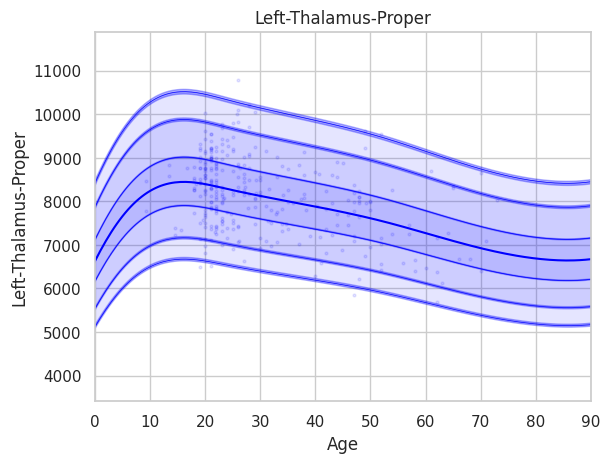

Running IDP 1 Left-Lateral-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([4721.02739666]), 'Rho': array([0.36854182]), 'pRho': array([3.2754096e-22]), 'SMSE': array([0.90563702]), 'EXPV': array([0.13491379])}
Insufficent data for site 9 Cleveland skipping...
Insufficent data for site 19 PaloAlto skipping...


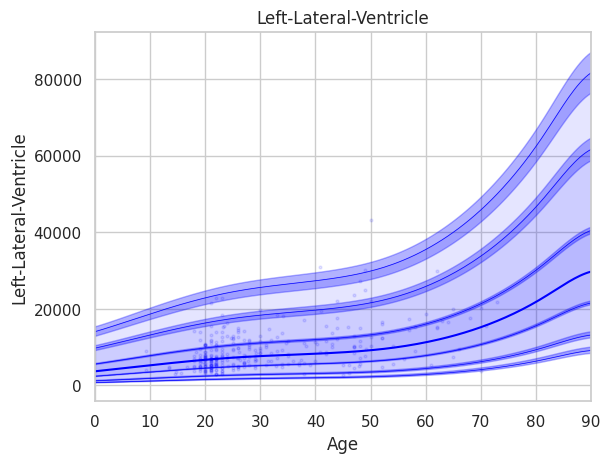

Running IDP 2 rh_MeanThickness_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07451234]), 'Rho': array([0.62880991]), 'pRho': array([1.17309752e-76]), 'SMSE': array([0.62073281]), 'EXPV': array([0.38835322])}
Insufficent data for site 9 Cleveland skipping...
Insufficent data for site 19 PaloAlto skipping...


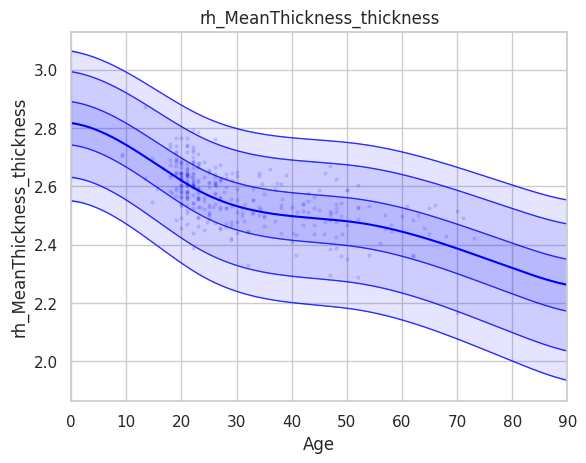

In [ ]:
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids):
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy,
                       alg = 'blr',
                       respfile = None,
                       model_path = os.path.join(idp_dir,'Models'),
                       outputsuffix = '_dummy')

    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle)

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1]

    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))

    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set

            # first, we select the data points belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue

            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset

            # first, select the data point belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, (df_te['site'] == site).to_numpy()))[0]

            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] == sex, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue

            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp,
                                                                   X_ad[idx_a,:],
                                                                   np.squeeze(y_ad[idx_a]),
                                                                   Xs=None,
                                                                   ys=np.squeeze(y_te[idx]))
        # plot the (adjusted) data points
        plt.scatter(X_te[idx,1], y_te_rescaled, s=4, color=clr, alpha = 0.1)

    # plot the median of the dummy data
    plt.plot(xx, med, clr)

    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

    plt.xlabel('Age')
    plt.ylabel(idp)
    plt.title(idp)
    plt.xlim((0,90))
    plt.savefig(os.path.join(idp_dir, 'centiles_' + str(sex)),  bbox_inches='tight')
    plt.show()

os.chdir(out_dir)

In [ ]:
# explore an example output folder of a single model (one ROI)
# think about what each of these output files represents.
# Hint: look at the variable names and comments in the code block above
! ls rh_MeanThickness_thickness/

centiles_1.png	    pRho_predict.txt  sitenum_ad.txt	ys2_dummy.pkl
cov_bspline_ad.txt  resp_ad.txt       sitenum_te.txt	ys2_predict.txt
cov_bspline_te.txt  resp_te.txt       SMSE_predict.txt	Z_predict.txt
EXPV_predict.txt    Rho_predict.txt   yhat_dummy.pkl
Models		    RMSE_predict.txt  yhat_predict.txt


In [ ]:
# check that the number of deviation scores matches the number of subjects in the test set
# there should be one deviation score per subject (one line per subject), so we can
# verify by counting the line numbers in the Z_predict.txt file
! cat rh_MeanThickness_thickness/Z_predict.txt | wc

    631     631   16052


The deviation scores are output as a text file in separate folders. We want to summarize the deviation scores across all models estimates so we can organize them into a single file, and merge the deviation scores into the original data file.

In [ ]:
! mkdir deviation_scores

In [ ]:
! for i in *; do if [[ -e ${i}/Z_predict.txt ]]; then cp ${i}/Z_predict.txt deviation_scores/${i}_Z_predict.txt; fi; done

In [ ]:
z_dir = '/content/braincharts/models/lifespan_57K_82sites/deviation_scores/'
filelist = [name for name in os.listdir(z_dir)]

In [ ]:
os.chdir(z_dir)
Z_df = pd.concat([pd.read_csv(item, names=[item[:-4]]) for item in filelist], axis=1)

In [ ]:
df_te.reset_index(inplace=True)

In [ ]:
Z_df['sub_id'] = df_te['sub_id']

In [ ]:
df_te_Z = pd.merge(df_te, Z_df, on='sub_id', how='inner')

In [ ]:
df_te_Z.to_csv('fcon1000_te_Z.csv', index=False)

## Questions
1. What are important considerations and challenges when creating large population-level reference samples for normative models?
2. How might the application of normative models, typically based on cross-sectional data, be extended to predict longitudinal trajectories? What potential challenges or limitations might arise?
3. Besides neuroimaging measures, what other types of measures, such as behavioral or clinical assessments, do you believe would benefit from having a reference cohort or normative model?


## Suggested further readings

1. [Evidence for embracing normative modeling](https://elifesciences.org/articles/85082)
2. [The normative modeling framework for computational psychiatry](https://www.nature.com/articles/s41596-022-00696-5)
3. [Charting brain growth and aging at high spatial precision](https://elifesciences.org/articles/72904)
4. [Brain Charts for the Human Lifespan](https://www.nature.com/articles/s41586-022-04554-y)
5. [Site effects how-to and when: An overview of retrospective techniques to accommodate site effects in multi-site neuroimaging analyses](https://pubmed.ncbi.nlm.nih.gov/36388214/)
